In [1]:
import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
Org=cv.imread("Samples/3.jpg")
Org=cv.resize(Org,(400,round(Org.shape[0]/Org.shape[1]*400)))
I=cv.cvtColor(Org,cv.COLOR_RGB2GRAY)


I=cv.GaussianBlur(I,(3,3),1.5)
I= cv.Canny(I,50,150,apertureSize = 3)
I_Hor= cv.morphologyEx(I, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(3,1)))
I_Hor= cv.morphologyEx(I_Hor, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT,(5,1)))
I_Vert= cv.morphologyEx(I, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_RECT,(1,3)))
I_Vert= cv.morphologyEx(I_Vert, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT,(1,5)))
I=(I_Hor+I_Vert)/2

kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,11))
I=cv.morphologyEx(I,cv.MORPH_CLOSE,kernel)
I=abs(I-np.max(I))


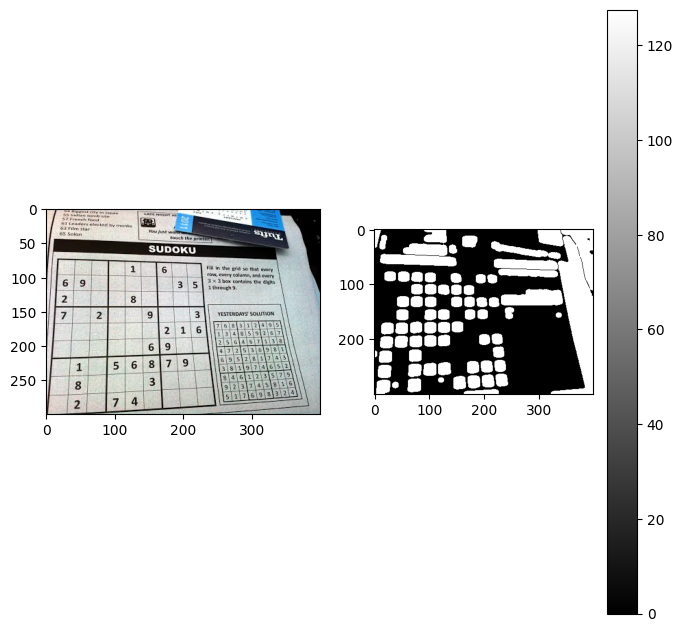

In [3]:


plt.subplot(131)
plt.imshow(Org)
plt.subplot(132)
plt.imshow(I)
plt.colorbar()
#plt.subplot(133)


300 400
Anzahl der Regionen 509


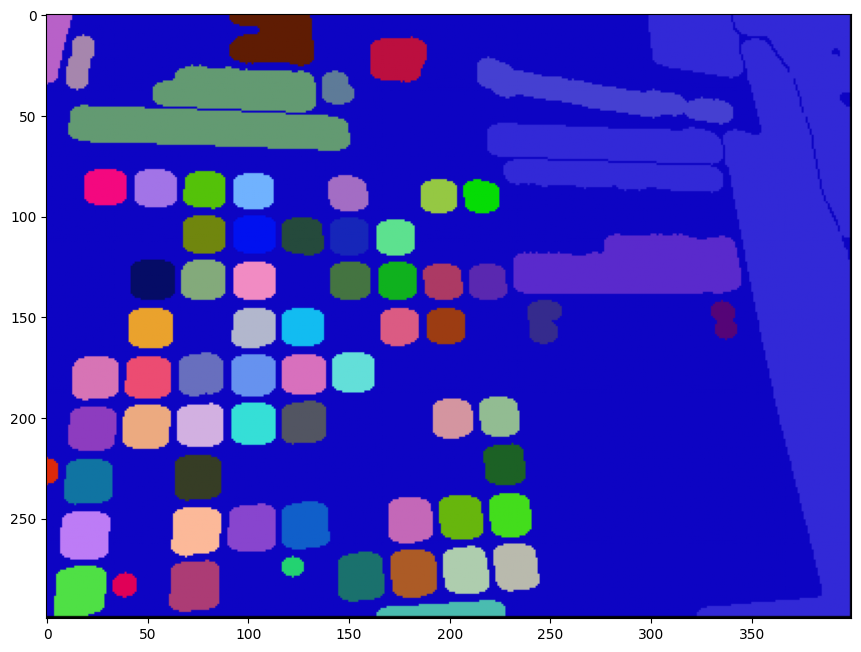

In [6]:
h,w=I.shape
regions=np.zeros((h,w))




def addNeigbours(i,j,neigbours):
    neigbours.append((i+1,j+1))
    neigbours.append((i+1,j))
    neigbours.append((i,j+1))
    neigbours.append((i-1,j+1))
    neigbours.append((i-1,j))
    neigbours.append((i+1,j-1))
    neigbours.append((i,j-1))
    neigbours.append((i-1,j-1))
        
cregion=1
print(h,w)

colors=[]
for j in range(w):
    for i in range(h):
        neigbours=[]
        if I[i,j]==0 or regions[i,j]!=0:
            continue
        else:
            regions[i,j]=cregion
            addNeigbours(i,j,neigbours)
        
        
        while(len(neigbours)):
            pos=neigbours.pop()
            if pos[0]<0 or pos[0]>=h-1 or pos[1]<0 or pos[1]>=w-1:
                continue
            #print(pos)
            if I[pos]!=0 and regions[pos]==0:
                regions[pos]=cregion
                addNeigbours(pos[0],pos[1],neigbours)
            
            
        cregion+=1
        colors.append(list(np.random.choice(range(255), size=3)/255))
        
        
#Gefunden Regionen anzeigen
img=np.zeros((h,w,3))   
print("Anzahl der Regionen", cregion)
for i in range(h-1):
    for j in range(w-1):
        #print(i,j)
        img[i,j]=colors[int(regions[i,j])]
        
        
plt.imshow(img)        
        

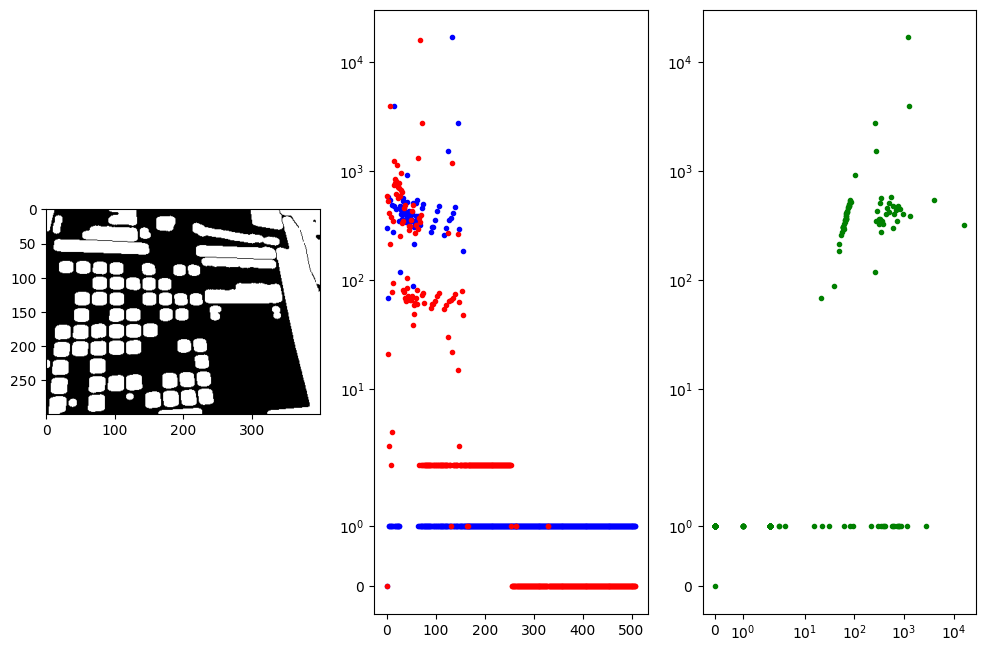

In [7]:

kernel=np.array(((0,1,0),(1,1,1),(0,1,0)),np.uint8)
borders=regions*(1-cv.erode(I,kernel)/255)
numreg=int(np.max(regions))
circs=np.zeros(numreg+1)
areas=np.zeros(numreg+1)

h,w=I.shape


for i in range(h):
    for j in range(w):
        areas[int(regions[i,j])]+=1
        circs[int(borders[i,j])]+=1
        
bgarea=areas[0]
areas[0]=0
circs[0]=0

mean=0
n=0
for i in range(len(circs)):
    if circs[i] and areas[i]>10:
        mean+=areas[i]
        n+=1
mean=mean/n
squares=[]
#print(mean,areas)
for i in range(len(circs)):
    r=((circs[i]/4)**2)/(areas[i]+1)
    if r>0.3 and r<0.8 and areas[i]/mean<4 and circs[i]:
        squares.append(1)
    else:
        squares.append(0)
        
plt.subplot(131)
plt.imshow(borders>0)



plt.subplot(132)
plt.plot(areas,"b.")
plt.plot(circs,"r.")
plt.yscale("symlog")
plt.subplot(133)
plt.plot(circs,areas,"g.")
plt.yscale("symlog")
plt.xscale("symlog")
plt.show()

508.0


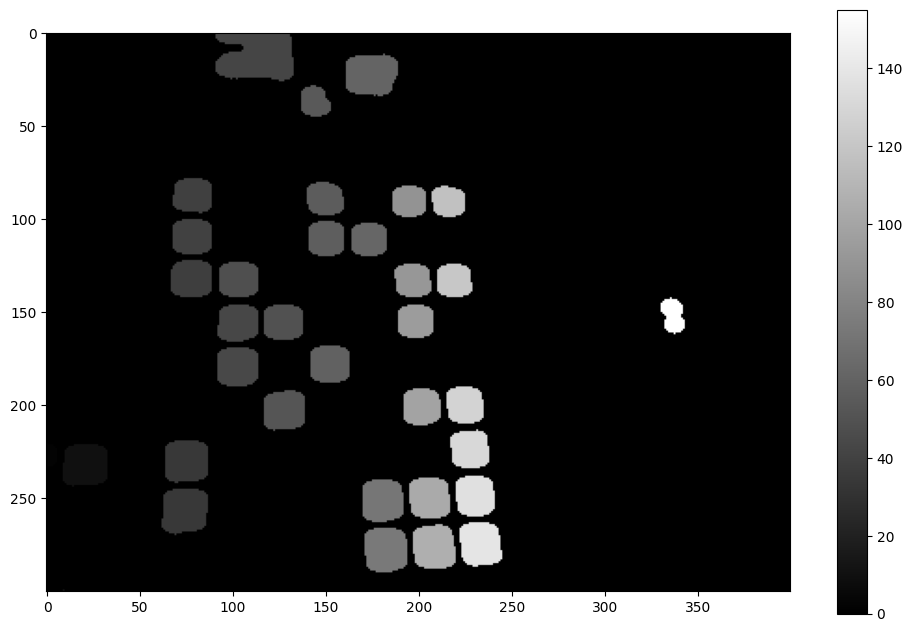

In [8]:
h,w=I.shape

I_roi=np.zeros((h,w))

for i in range(h):
    for j in range(w):
        I_roi[i,j]=regions[i,j]*squares[int(regions[i,j])]
        
plt.imshow(I_roi)
plt.colorbar()

print(np.max(regions))

In [9]:
I=I_roi
cogx=np.zeros(int(np.max(I))+1)
cogy=np.zeros(int(np.max(I))+1)
numpix=np.zeros(int(np.max(I)+1))

h,w=I.shape

for i in range(h):
    for j in range(w):
        pos=int(I[i,j])
        cogy[pos]+=i
        cogx[pos]+=j
        numpix[pos]+=1

numpix[0]=0
mean=np.sum(numpix)/np.count_nonzero(numpix)
      
for i in range(1,len(cogx)):
    if numpix[i]:
        cogx[i]=cogx[i]/numpix[i]
        cogy[i]=cogy[i]/numpix[i]


delta=1.41*int(np.sqrt(mean))
for i in range(1,len(cogx)):
    if numpix[i]<0.1*mean:
        squares[i]=0
        continue
        
    xmin,ymin,xmax,ymax=cogx[i]-delta,cogy[i]-delta,cogx[i]+delta,cogy[i]+delta
    if xmax>w:
        xmax=w
    if ymax>h:
        ymax=h
    if ymin<0:
        ymin=0
    if xmin<0:
        xmin=0
    SW=I[int(ymin):int(ymax),int(xmin):int(xmax)]
    
    #print(cogx[i],cogy[i],numpix[i])
    if(np.count_nonzero(SW)<=numpix[i]):
       squares[i]=0

print(mean,delta)

375.37142857142857 26.79


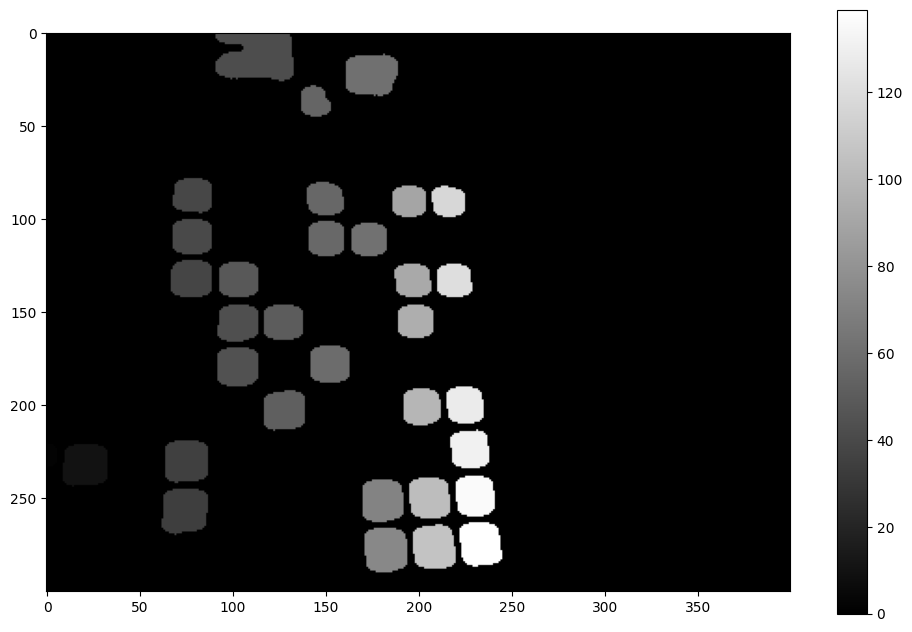

In [10]:
h,w=I.shape


I_roi=np.zeros((h,w))

for i in range(h):
    for j in range(w):
        I_roi[i,j]=regions[i,j]*squares[int(regions[i,j])]
        
plt.imshow(I_roi)
plt.colorbar()



In [11]:
I=I_roi
points=[[h,w],[w,0],[0,h],[0,0]]
h,w=I.shape[0],I.shape[1]
scale=0.9

for i in range(h):
    for j in range(w):
        if I[i,j]:
            d0=i*i+j*j
            d1=(h-i-1)**2+j*j
            d2=i*i+(w-j-1)**2
            d3=(h-i-1)**2+(w-j-1)**2
            
            if d0<(points[0][0]**2+points[0][1]**2):
                points[0]=[j,i]
                
            if d1<=((h-points[1][1]-1)**2+points[1][0]**2):
                points[1]=[j,i]
                
            if d2<=(points[2][1]**2+(w-points[2][0]-1)**2):
                points[2]=[j,i]
                
            if d3<=((h-points[3][1]-1)**2+(w-points[3][0]-1)**2):
                points[3]=[j,i]
                
#points[0]=np.round([scale*points[0][0],scale*points[0][1]])
#points[1][0]=np.round(scale*points[1][0])
#points[1][1]=np.round((h-points[1][1]-1)*(1-scale)+points[1][1])
#points[2][0]=np.round(points[2][0]+(w-points[2][0]-1)*(1-scale))
#points[2][1]=np.round(scale*points[2][1])
#points[3]=np.round([points[3][0]+(w-points[3][0]-1)*(1-scale),(h-points[3][1]-1)*(1-scale)+points[3][1]])


print(points)      


[[91, 0], [14, 243], [224, 86], [244, 282]]


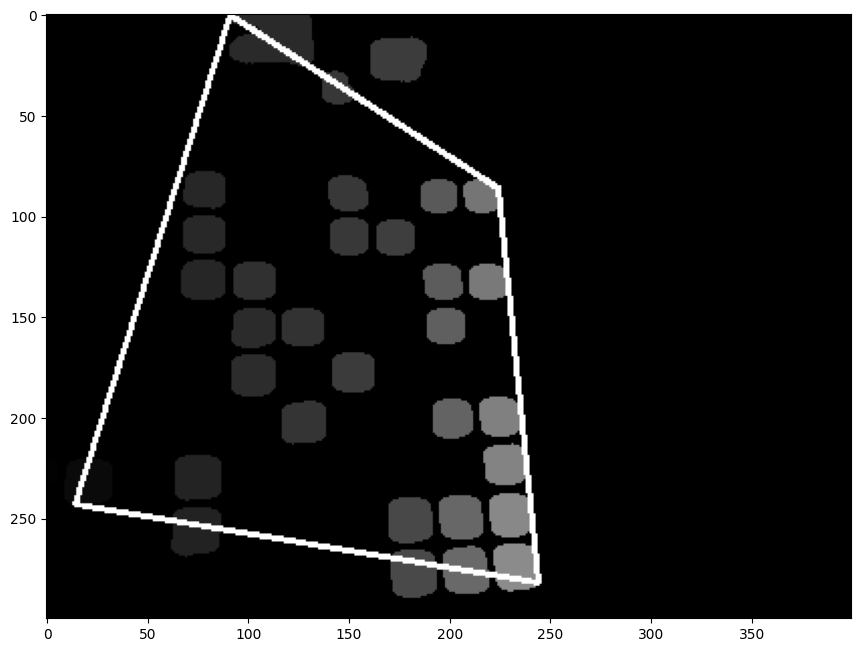

In [12]:
ROI=I.copy()
#pts = np.array(([points[0][1],points[0][0]],[points[1][1],points[1][0]],[points[3][1],points[3][0]],[points[2][1],points[2][0]]),np.int32) 
pts=np.int32([points[0],points[1],points[3],points[2]])
pts = pts.reshape((-1, 1, 2)) 
plt.imshow(cv.polylines(ROI, [pts],True, (255,255,0),2))

[[ 5.00809479e-01  1.97442236e-01 -3.40828840e+01]
 [-5.00285589e-01  7.40589560e-01  5.70167672e+01]
 [-2.57085814e-03  1.76866727e-03  1.00000000e+00]]


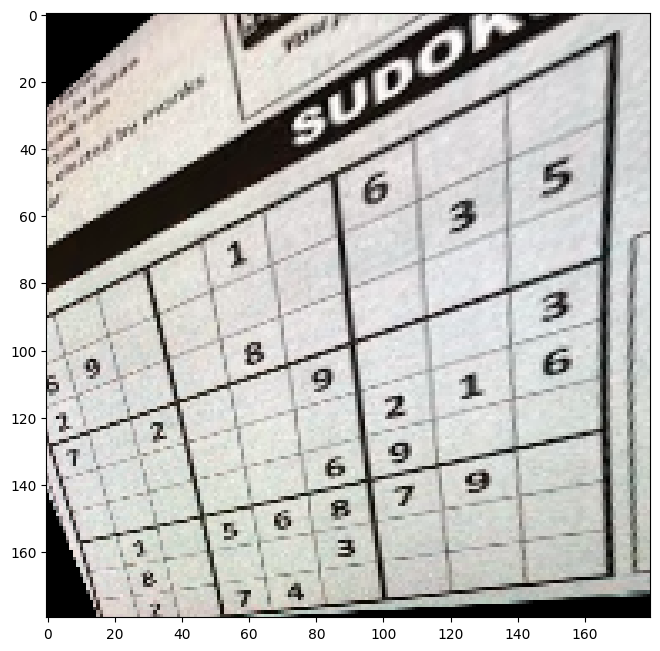

In [13]:
pts1 = np.float32(points)
pts2 = np.float32([[15,15],[15,165],[165, 15],[165, 165]])
trans = cv.getPerspectiveTransform(pts1, pts2)
print(trans)
im_out = cv.warpPerspective(Org, trans, (180,180))
plt.imshow(im_out)
